# Building your own Object Detector from scratch

This exercise is based on notebook from doleron (https://github.com/doleron/simple-object-detector-from-scratch). The original notebook is further explained in a story on medium: https://medium.com/@doleron/building-your-own-object-detector-from-scratch-bfeadfaddad8. The data is taken from https://www.kaggle.com/datasets/techzizou/labeled-mask-dataset-yolo-darknet.

The object detector, which will be build on Tensorflow and Keras, will detect people where some people do and some do not wear masks.

## 1 Imports

In [68]:
import pathlib  # Creating paths independentyl of the file system
import shutil   # Unpacking zip
import cv2 as cv    # Image processing
import numpy as np  # Working with vectors and matrices
from matplotlib import pyplot as plt  # Printing images, plotting graphs  
import os   # Accessing the file system
import random   # Create random order for the dataset
import tensorflow as tf # Building the model

## 2 Reading in the data

The data is given to you as a zip archive. It contains images of people that do or do not wear masks. Additionally it contains annotations for each picture.

In [69]:
# unpack the archive
shutil.unpack_archive("data/archive.zip", "data/")

data_dir = pathlib.Path("data/obj/").with_suffix('')

# Store all images in image_files
image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

1510


**Expected Output**: 1510

As the archive is unpacked, we can now have a look at a sample image. 

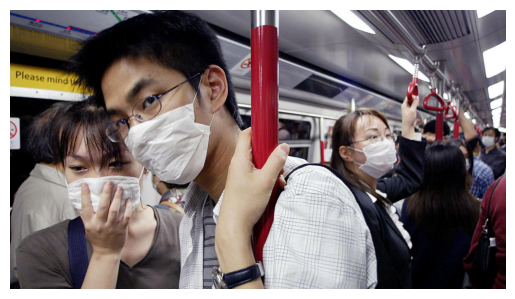

In [70]:
# print image[0]
sample_img_path = str(image_files[0])
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

For each picture the data provides a text file with according annotations. Each annotation consists of five values. The first value denotes the class where 0 stands for a person wearing a mask and 1 standing for a person not wearing a mask.
The following four values describe a bounding box over the persons head. The values represent the x, y, width and height of the box in percent.

#### Exercise: Get the right annotation
The annotations are stored in '.txt' files that, apart from the file extension, have the same name as the images. Your first task is to get the path to the image that you just printed. 

Hint: To get every but the last four characters from a string use example_string[0:-4].

In [71]:
### START CODE HERE ### (≈ 1 line)
sample_annotation_path = sample_img_path[0:-4] + '.txt'
### END CODE HERE ###
with open(sample_annotation_path) as f:
    print(f.readlines())

['0 0.9679166666666666 0.4562962962962963 0.034166666666666665 0.08888888888888889\n', '0 0.7141666666666666 0.4837037037037037 0.13833333333333334 0.25037037037037035\n', '0 0.3016666666666667 0.34074074074074073 0.33666666666666667 0.6044444444444445\n', '0 0.1875 0.5325925925925926 0.17666666666666667 0.42814814814814817']


**Expected output:**
['0 0.4734375 0.5739030023094688 0.665625 0.5612009237875288\n']

To successfully read the annotations, we need them to be in the specified format. Annotations must only contain one line.
The valid files are further devided into a training and a validation set to have an indicator for overfitting.

#### **Exercise: Split the data**
The file names of all valid files are collected for you and stored in the array 'files'. Your task is to split the array in a traing set containing split_percentage of the data and a validation set containing the remaining files.


In [72]:
def list_files(full_data_path = "data/obj/", image_ext = '.jpg', split_percentage = 80):
    """ Check for valid annotations (only one line), get the according images and split the data into a training and validation set

    Arguments:
    full_data_path -- String with path to the folder containing the data
    image_ext -- String with file extension of the images
    split_percentage -- Number in percent defining how many of the image are to be used for training

    Returns:
    training_files -- Array containing the file names of the training images
    validation_files -- Array containing the file names of the validation files
    """
    

    files = []

    discarded = 0
    masked_instance = 0

    # Get all valid images
    for _, _, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # Check the format of the annotations. Annotations should constist of just one line.
                # Discard images with an invalid annotation
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue
                    
                # Get the file name of the sample without any extension
                strip = file[0:len(file) - len(".txt")] 

                # Check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # Count the number of masked images
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    # Mix the order of the images
    random.shuffle(files)

    # Split the files array by the trainigng percentage
    ### START CODE HERE ### (≈ 3 lines)
    split_training = int(split_percentage * size / 100)
    training_files = files[0:split_training]
    validation_files = files[split_training:]
    ### END CODE HERE ###

    return training_files, validation_files


In [73]:
training_files, validation_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")

218 file(s) discarded
1292 valid case(s)
832 are masked cases
1033 training files
259 validation files


Expected Output:
218 file(s) discarded
1292 valid case(s)
832 are masked cases
1033 training files
259 validation files

This dataset is relatively small. We only have 1033 images to train our model

We now have the names of the files. The next steps are to combine the images with the right annotations.
Moreover, the images need to be formatted to the input size of the model.

#### **Exercise**: Convert the data
The images in the dataset have varying dimensions. The model we are going to build expects images of size 244x244 as input. Therefore, your next task is to convert the images to the right size. Because we change the size of the images, you will also have to adjust the position and size of the boxes. Moreover, the annotations store the box parameters relative to the size of the width/height of the image in percent. For printing the images, you have to calculate the absolute values of these parameters.

Hints:
- By deviding the bigger of the two image dimensions through the input_size of the model, you will get a factor by which you can scale your images width and height
- 'new_size' should be a tuple containing the new width and height (new_size = (new_width, new_height))
- The x and y coordinates from the annotations denote the center of the box. However, opencv expects the coordinates of the top right corner of the box. Therefore, you will have to move the x and y to the top right corner before moving the box
- Calculate the absolute values of the x, y, width and heigth by multiplying by the original width or height of the image 
- Round all results to the nearest integer


In [74]:
input_size = 244

def format_image(img, box):
    """Format images and boxes to fit the input size of the model (244x244)

    Arguments:
    img -- array of shape (height, width)
    box -- array of shape (4), containing the boxes x, y, width and height in percent

    Returns:
    new_image -- array of shape (244x244), containing the reshaped image
    new_box -- array of shape (4), containing the formatted box in absolut values
    """

    # Calculate the new_size of the image
    ### START CODE HERE ### (≈ 5 lines)
    height, width = img.shape 
    max_size = max(height, width)
    r =  input_size / max_size
    new_width = int(width * r)
    new_height = int(height * r)
    new_size = (new_width, new_height)
    ### END CODE HERE ###

    # Resize the image to the calcualted size and fill the smaller dimension with black pixels (zeros) to get a 244x244 image
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    # Move and resize the box accordingly and convert the parameters to be absolute
    ### START CODE HERE ### (≈ 2 lines)
    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width * r), int((y - 0.5*h) * height * r), int(w*width * r), int(h*height * r)]
    ### END CODE HERE ###

    return new_image, new_box

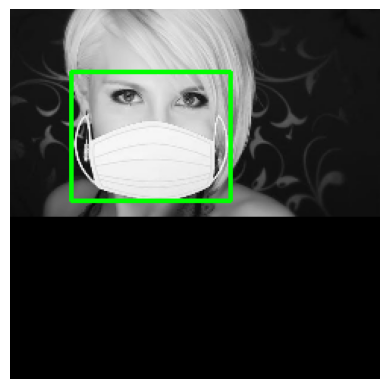

Formatted image shape:  (244, 244)
Formatted bounding box:  [40, 41, 106, 86]


In [75]:
# Get an image and its bounding box
temp_img = cv.imread("data/obj/5-with-mask.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.38183279742765275, 0.6171428571428571, 0.43569131832797425, 0.6285714285714286]

# Format the image and the box to a 244x244 image
temp_img_formated, box = format_image(temp_img, temp_box)

# Save the grayscale image as rgb to be able to add a colored bounding box
temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

# Add the bounding box
cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

# Print
plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

print("Formatted image shape: ", temp_img_formated.shape)
print("Formatted bounding box: ", box)

Expected output:
Formatted image shape:  (244, 244)
Formatted bounding box:  [40, 41, 106, 86]

Now that you have the file paths and the functionality to format images and bounding boxes, as a last step of reading in the data you will create an optimized tensorflow dataset. 

In [76]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Check if you have a running tensorflow version
print(tf.__version__)

2.12.0


In [77]:
# Read in the images, normalize the data and store it in a tensor
def data_load(files, full_data_path = "data/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        # Read the image in as a grayscale image
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        # Read in the annotations
        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        # Scale image and box
        img, box = format_image(img, box)
        
        # Normalize the image
        img = img.astype(float) / 255.
        # The model needs the box parameters as relative values
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    # Convert images and boxes to tensors
    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [78]:
# Load the training and validation files
raw_train_ds = data_load(training_files)
raw_validation_ds = data_load(validation_files)

Set up training and validation files in order to follow the tensorflow guideline (https://www.tensorflow.org/datasets/performances):

In [80]:
CLASSES = 2 # Masked and not masked

# Format the lable
def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [81]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

# Set training parameters like the batch size
def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [82]:
# Tune the train dataset
train_ds = tune_training_ds(raw_train_ds)

In [83]:
# Set validation parameters like the batch size
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [84]:
# Tune the validation dataset
validation_ds = tune_validation_ds(raw_validation_ds)

Now the data is ready for the model. You can print the first batch from the training dataset together with it's annotations. Green boxes represent people wearing a mask, blue boxes represent people without a mask.

2024-01-13 15:30:36.504934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1033,5]
	 [[{{node Placeholder/_1}}]]
2024-01-13 15:30:36.506057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1033,5]
	 [[{{node Placeholder/_1}}]]


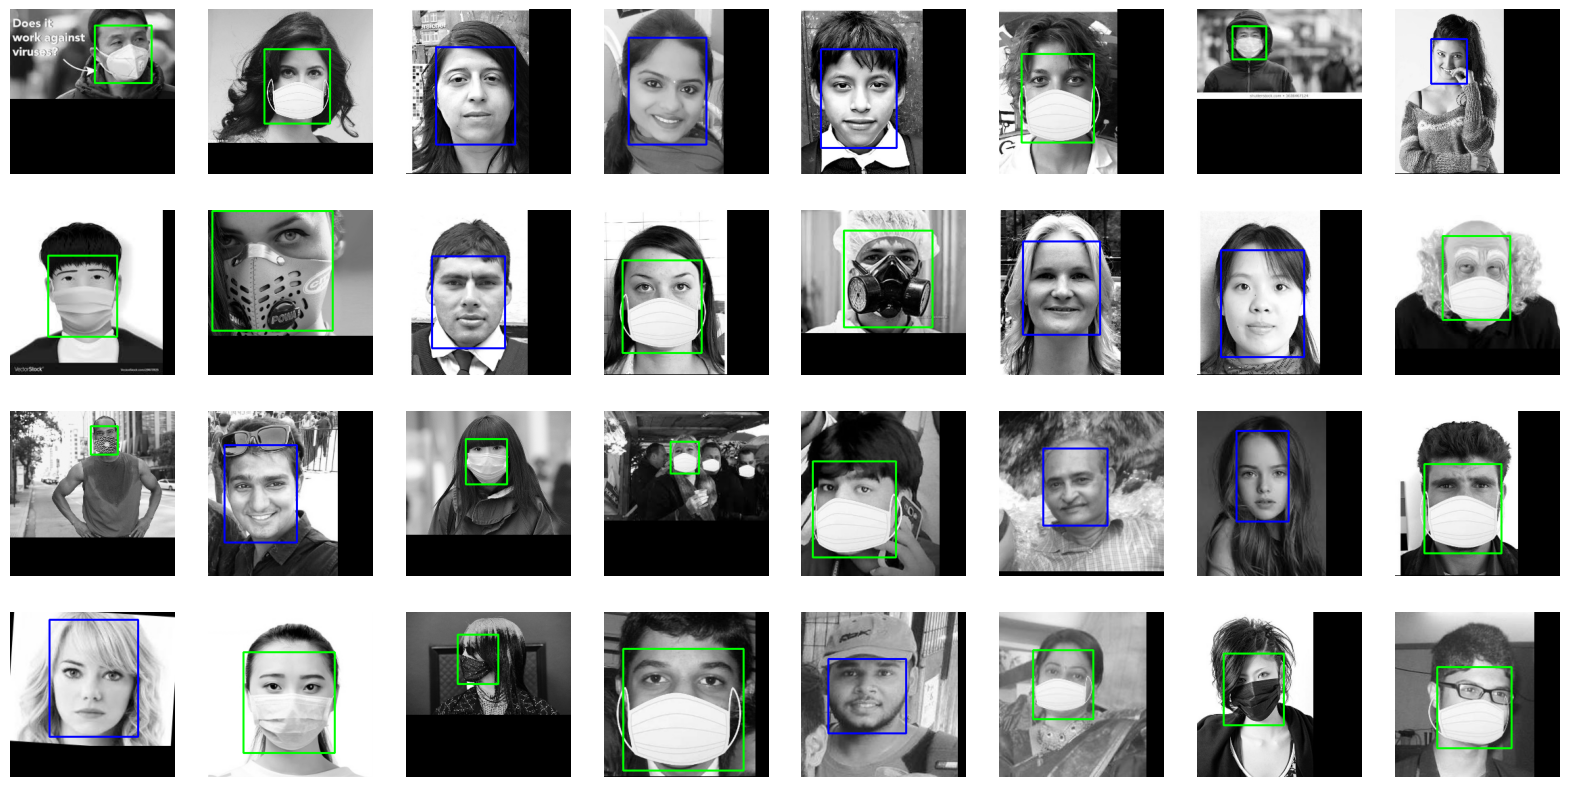

In [85]:
# Print the first batch from the train dataset with a visualization of its annotations
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

## 3 Building the model
In the following you will build the model for the object detector. Since we have a limited ammound of data (and calculation power) the model is keept relatively small.
It consists of two parts: Classifying the object (label) and localizing it in the image (bounding box). Both problems share a common structure. The model will first need to identify the features in the image to than be able to classify or localize the object. Therefore, the concept of transfer learning can be used in this example. As a backbone a feature extractor consisting of three convolutional layers each followed by average pooling layers is used. Each problem than has it's own head to return the final output. For the classification a dense layer with two outputs for the two classes is used. For the localization of the object a dense layer with four outputs defining a bounding box is used. The two heads are conneced to the backbone through a model adaptor that flattens the backbones output.

In [86]:
DROPOUT_FACTOR = 0.5

# Shared backbone
def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

# Connection from the backbone to the two heads
def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

# Head for the classification problem
def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

# Head for the localization problem
def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

# Connect the parts into one model
def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

Each network head has a specific set of loss function and metrics. With the following cell you can print a summary of the model.

In [87]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 242, 242, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 121, 121, 16  0          ['conv2d[0][0]']                 
 ing2D)                         )                                                             

You can also print the model as graph:

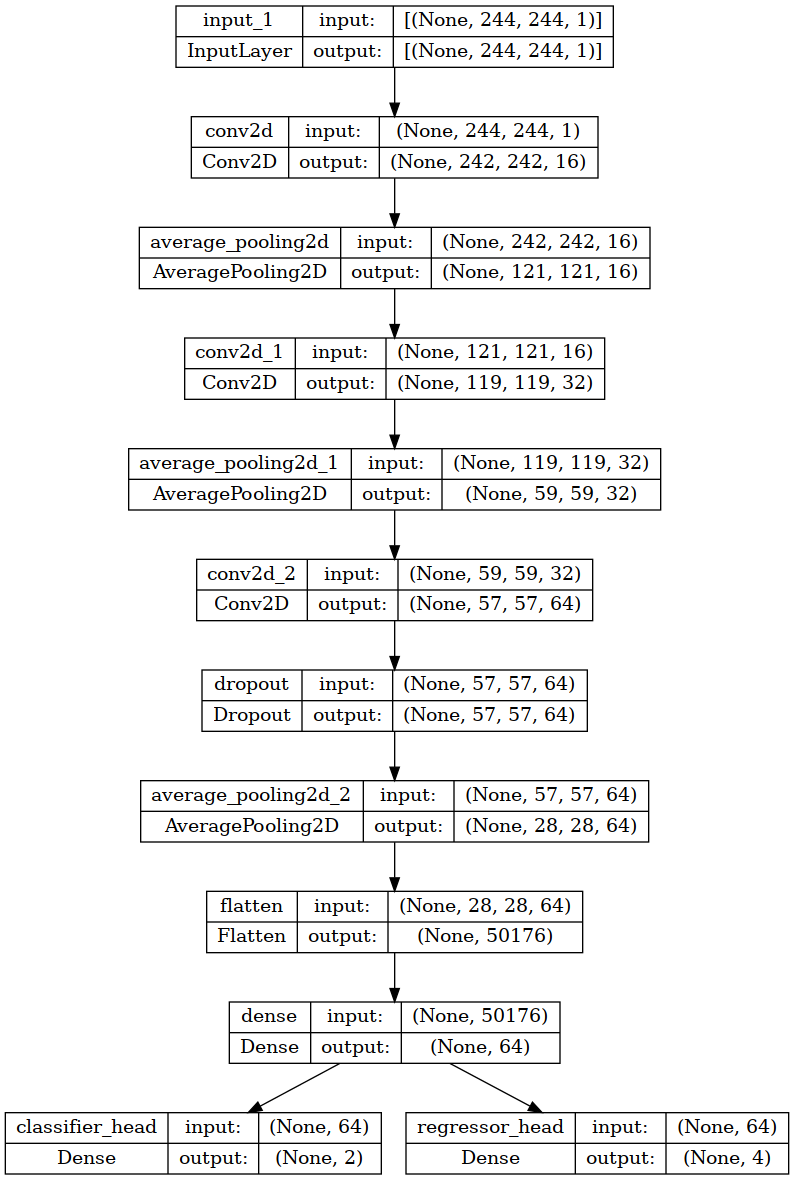

In [88]:
# plot_model requires graphviz & pydot
# see https://github.com/XifengGuo/CapsNet-Keras/issues/7#issuecomment-370745440
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

## 4 Training the model

With the data read in and the model set up, we can now train the model. When reading in the data you have set the batch size to 32. Running the model for 25 epochs will result in sufficient results. Training the over three million parameters might take some time.

In [89]:
EPOCHS = 25

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=EPOCHS)

Epoch 1/25


2024-01-13 15:30:38.583280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1033,244,244,1]
	 [[{{node Placeholder/_0}}]]
2024-01-13 15:30:38.583619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1033,244,244,1]
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 0.6325 - classifier_head_loss: 0.5974 - regressor_head_loss: 0.0351 - classifier_head_accuracy: 0.6738 - regressor_head_mse: 0.0351

2024-01-13 15:30:57.279947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [259,5]
	 [[{{node Placeholder/_1}}]]
2024-01-13 15:30:57.281986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [259,5]
	 [[{{node Placeholder/_1}}]]


32/32 [==============================] - 19s 536ms/step - loss: 0.6325 - classifier_head_loss: 0.5974 - regressor_head_loss: 0.0351 - classifier_head_accuracy: 0.6738 - regressor_head_mse: 0.0351 - val_loss: 0.5213 - val_classifier_head_loss: 0.5055 - val_regressor_head_loss: 0.0158 - val_classifier_head_accuracy: 0.7656 - val_regressor_head_mse: 0.0158
Epoch 2/25
32/32 [==============================] - 16s 516ms/step - loss: 0.5197 - classifier_head_loss: 0.4952 - regressor_head_loss: 0.0245 - classifier_head_accuracy: 0.7988 - regressor_head_mse: 0.0245 - val_loss: 0.4226 - val_classifier_head_loss: 0.4018 - val_regressor_head_loss: 0.0208 - val_classifier_head_accuracy: 0.7656 - val_regressor_head_mse: 0.0208
Epoch 3/25
32/32 [==============================] - 16s 505ms/step - loss: 0.4263 - classifier_head_loss: 0.4008 - regressor_head_loss: 0.0255 - classifier_head_accuracy: 0.8438 - regressor_head_mse: 0.0255 - val_loss: 0.3270 - val_classifier_head_loss: 0.3081 - val_regressor_

While training we saved the history of the model accuracy and classification/bounding box loss. You can plot those below.

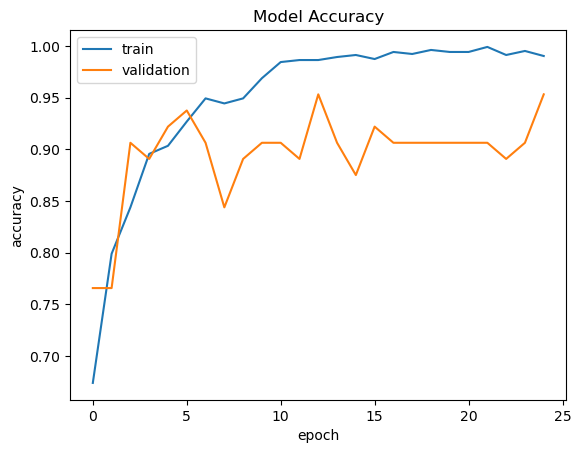

In [90]:
# Plot the model accuracy for the train and validation set. 
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

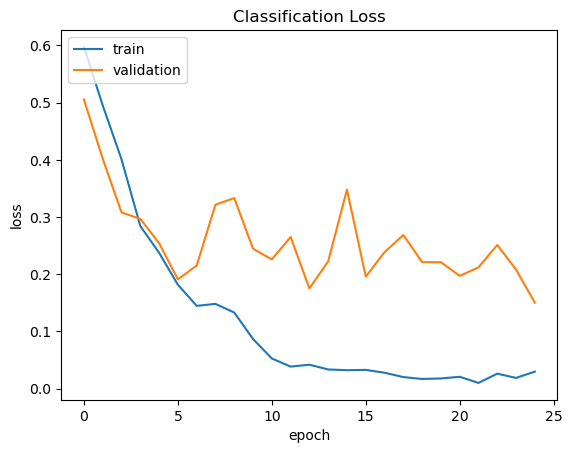

In [91]:
# Plot the classification loss for the train and validation set. 
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

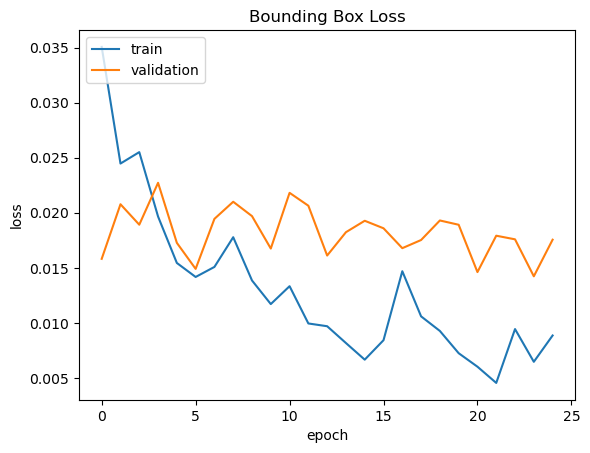

In [92]:
# Plot the bounding box loss for the train and validation set. 
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 5 Evaluation
#### **Exercise: Intersection over union**
For your last task you are introduced in the concept of the intersection over union (iou). Iou is common metric to evaluate the bounding box performance. By deviding the area of intersection through the area of union a score is calculated where a higher score means that the two boxes match better. The concept is visualied in figure 1.

<img src="iou.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 1** </u>: Definition of "Intersection over Union". <br> </center></caption>

Your task is to implement the intersection over union for two given boxes.

Hints:
- A box is represented by the x and y of the upper left corner and it's width and heigth
- The images coordinate system has it's origin in the upper left corner. Positive x is defined to the right, positive y is definied towards the bottom
- For calculating the area of the intersection calculate the x and y of the upper left and the lower right corner of the intersection. For the upper right corner's x take the maximum of the upper right corners x values of the two input boxes. For the y value of the upper left takte the maximum of the y values. For the lower right corner do so accordingly with the minimum values
- Than calculate the area of the intersection by multiplying it's with (x_lower_right - x_upper_left) and height (y_lower_right - y_upper_left)
    - You can optionally increase the width and height by one bevore multiplying to make sure you don't later devide by zero
    - Before multiplying take the maximum of the width/height and zero to catch the case of having no overlap
- For the union area add the areas of boxA and boxB and substrack the previously calculated union
    - You can again optionally increase width and height by one before multiplying to make sure you do not get 0 as a result
- Finally the iou is calculated by deviding the intersection area through the union area

In [93]:
def intersection_over_union(boxA, boxB):
	""" Calculate the intersection over union between boxA and boxB

	Arguments:
	boxA -- Array of size four parameters defining the x, y, width and height of the first box
	boxB -- Array of size four parameters defining the x, y, width and height of the second box

	Returns:
	iou -- Calculated intersection over union
	"""
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

Because of the limited number of sample images, no test set was created. For this final evaluation of the model, images form the validation set will be reused. Green boxes represent correct classification. Red boxes indicate wrong classification  

2024-01-13 15:40:20.470222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [259,5]
	 [[{{node Placeholder/_1}}]]
2024-01-13 15:40:20.470556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [259,5]
	 [[{{node Placeholder/_1}}]]


20


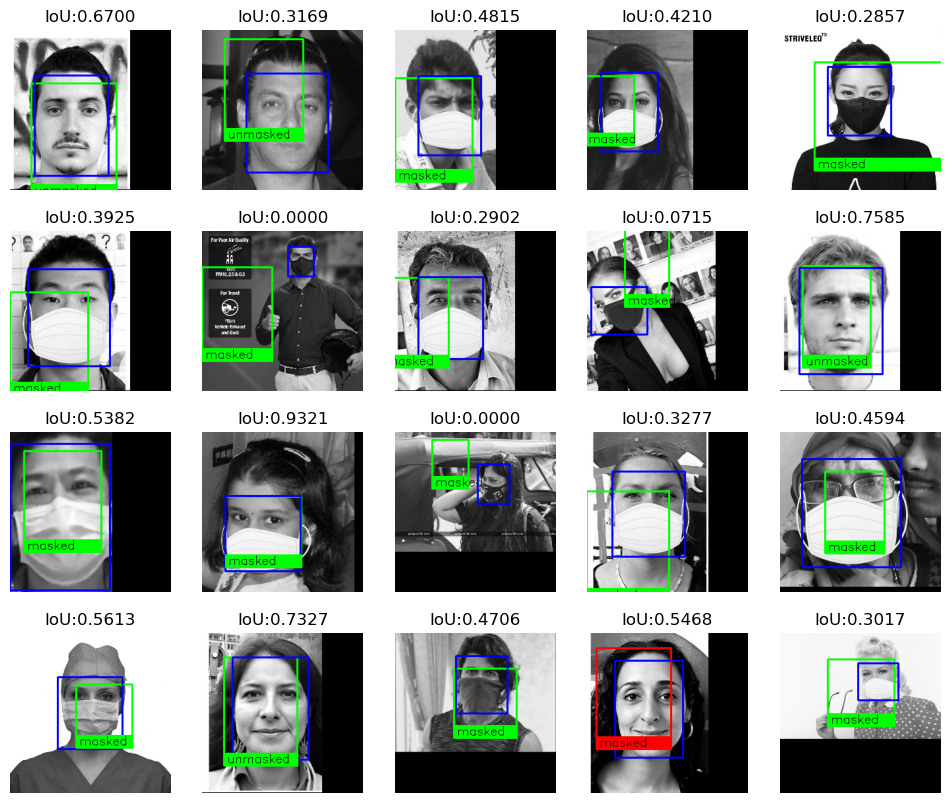

In [97]:
# Plot images from the validation set with the reference box, the predicted box, the predicted classification and the calculated iou
plt.figure(figsize=(12, 10))

test_list = list(validation_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 5, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

## 6 Conclusion
In this lection you have learned how a simple object detector can be created from scratch and how the quality of bounding boxes can be measured by using the intersection over union method.
Moreover, you have revisited the concept of transfer learning by connecting the object detection with a classification.

The model you have created is relatively small. While performing suprisingly well on the given data, it will not be capable to handle applications outside of an educational context. If you were to work on any practical applications you would use a pretrained network like YOLO.